## Kaggle Titanic Challange - ML Workflow

In this project we're going to build a ML workflow based on the Kaggle Titanic competition. We will use a pipeline of functions to connect all the steps: data cleaning, feature enginerring, feature selectiona and machine learning.

The aim of the competition is to predict which passengers survived the Titanic disaster.

### 1. Exploratio of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('mode.chained_assignment', None)

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
print(train.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The data set contains 12 columns. Our target column is 'Survived'. Some of the features have missing values. The train set has 891 entries.

In [4]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The holdout set has 418 entries.

### 2. Data set cleaning and feature engineering

We will clean the dataset step by step.

Let's look on the Age column.

In [5]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

The missing values of the Age column will be filled in with -0.5 value and then we will split the Age column into six categories according to the age:
   - Missing, from -1 to 0
   - Infant, from 0 to 5
   - Child, from 5 to 12
   - Teenager, from 12 to 18
   - Young Adult, from 18 to 35
   - Adult, from 35 to 60
   - Senior, from 60 to 100

In [6]:
def process_age(df):
    """Process the Age column into pre-defined 'bins' 
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

process_age(train).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult


We will fill in the missing vaues in the Fare and Embarked columns with the mean and most common value, respectively.

In [7]:
def process_missing(df):
    """Handle various missing values from the data set
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

process_missing(train).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult


In [8]:
train.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            0
Age_categories      0
dtype: int64

We will convert the Fare values into bins similar to the Age column:
   - 0-12, for values between 0 and 12.
   - 12-50, for values between 12 and 50.
   - 50-100, for values between 50 and 100.
   - 100+, for values between 100 and 1000.

In [9]:
def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

process_fare(train).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Fare_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,0-12
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,50-100
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0-12
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,50-100
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,0-12


It seems like the letter in the Cabin number is representative of the type of cabin, which could be useful data for us. We can extract this letter from the Cabin column.

In [10]:
def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df.drop('Cabin',axis=1, inplace=True)
    return df

process_cabin(train).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Cabin_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Unknown


Looking at the Name column we can see titles like 'Mr' or 'Mrs', as well as some less common titles, like the 'Countess'. By spending some time researching the Kaggle forum, we can find out that we can categorize these into six types:
   - Mr
   - Mrs
   - Master
   - Miss
   - Officer
   - Royalty

In [11]:
def process_titles(df):
    """Extract and categorize the title from the name column 
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

process_titles(train).head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Fare_categories,Cabin_type,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,0-12,Unknown,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,50-100,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,0-12,Unknown,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,50-100,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,0-12,Unknown,Mr


Now we will convert the Age_categories, Fare_categories, Title, Cabin_type, Sex into the Dummy columns.

In [12]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for col in ["Age_categories", "Fare_categories","Title", "Cabin_type",
                "Sex"]:
    train = create_dummies(train, col)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Cabin_type          

#### Creating a single function which will clean the training and houlout data sets

Now we can combine all of the function into a one in order to perform the same cleaning for the holdout column.

In [13]:
#Creatind a function for data cleaning
def data_cleaning(df):
    """
    Combines all the created functions in order to to clean the dataset
    """
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type",
                "Sex"]:
        df = create_dummies(df, col)   
    return df

Cleaning of the holdout datasets

In [14]:
train_clean = train.copy()
holdout_clean = data_cleaning(holdout)
print(holdout_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 418 non-null    int64   
 1   Pclass                      418 non-null    int64   
 2   Name                        418 non-null    object  
 3   Sex                         418 non-null    object  
 4   Age                         418 non-null    float64 
 5   SibSp                       418 non-null    int64   
 6   Parch                       418 non-null    int64   
 7   Ticket                      418 non-null    object  
 8   Fare                        418 non-null    float64 
 9   Embarked                    418 non-null    object  
 10  Age_categories              418 non-null    category
 11  Fare_categories             418 non-null    category
 12  Title                       418 non-null    object  
 13  Cabin_type          

Noe we're going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

In [15]:
explore = train_clean[['SibSp', 'Parch', 'Survived']]
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


In [16]:
explore[['SibSp', 'Parch']].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


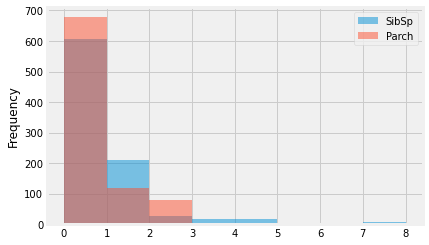

In [17]:
#Investigating the SibSp and Parch values
explore[['SibSp', 'Parch']].plot.hist(alpha=0.5,bins=8)
plt.show()

We can create a new column familysize by adding the SibSp and Parch.

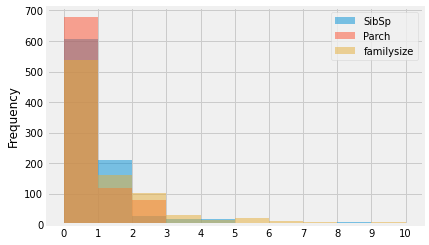

In [18]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

We will compare the survival rate for all three columns.

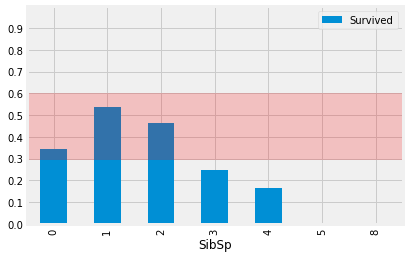

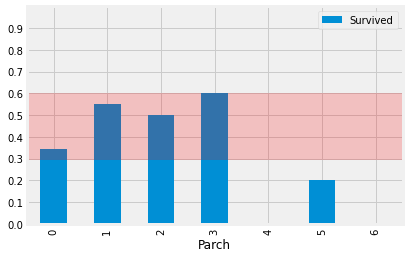

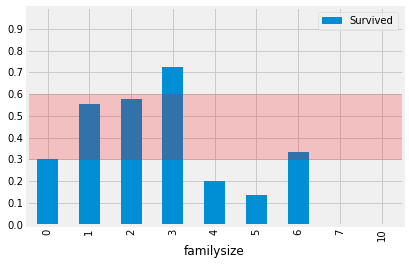

In [19]:
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

By combining the values of SibSp and Parch into a single column, only 30% of the passengers who had no family members onboard survived.
Based of this, we can creat a new feature - was the passenger alone. This will be a binary column containing the value:
- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [20]:
def isalone(df):
    """
    Function that checks if the passenger was alone on Titanic
    """
    mask = (df['SibSp'] == 0)&(df['Parch'] == 0)
    df['isalone'] = 0
    df.loc[mask,'isalone'] = 1
    return df

In [21]:
train_clean = isalone(train_clean)
holdout_clean = isalone(holdout_clean)
print(train_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 891 non-null    int64   
 1   Survived                    891 non-null    int64   
 2   Pclass                      891 non-null    int64   
 3   Name                        891 non-null    object  
 4   Sex                         891 non-null    object  
 5   Age                         891 non-null    float64 
 6   SibSp                       891 non-null    int64   
 7   Parch                       891 non-null    int64   
 8   Ticket                      891 non-null    object  
 9   Fare                        891 non-null    float64 
 10  Embarked                    891 non-null    object  
 11  Age_categories              891 non-null    category
 12  Fare_categories             891 non-null    category
 13  Cabin_type          

Now lets drop all of the initial columns which were used for feature engineering.

In [22]:
train_clean.drop(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 
                  'Embarked', 'Age_categories', 'Fare_categories', 'Cabin_type', 'Title'], axis=1, inplace=True)

In [23]:
holdout_clean.drop(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
                    'Embarked', 'Age_categories', 'Fare_categories', 'Cabin_type', 'Title'], axis=1, inplace=True)

### 3. Feature selection

We will create a function that uses scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

Let's write a function that:

- Accepts a dataframe as input
- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

In [24]:
def select_features(df):
    df_feature = df.select_dtypes([np.number]).dropna(axis=1)
   

    all_X = df_feature.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df_feature['Survived']
    
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    
    best_features = list(all_X.columns[selector.support_])
    
    print('The list of the best features: {}'.format(best_features))
    return all_X.columns[selector.support_]

In [25]:
features = select_features(train_clean)

The list of the best features: ['Fare_categories_0-12', 'Title_Mr', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


### 5. Model selection and tuning

We will write a function to do the heavy lifting of model selection and tuning. The function will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries — that is, a list where each element of the list is a dictionary. Each dictionary should contain:

- The name of the particular model
- An estimator object for the model
- A dictionary of hyperparameters that we'll use for grid search.

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's model_selection.GridSearchCV class to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

Finally, we can return the list of dictionaries, which will have our trained GridSearchCV objects as well as the results so we can see which was the most accurate.

In [26]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    model_list = [
        {'name': 'LogisticRegression',
         'estimator': LogisticRegression(),
         'hyperparameters':{"solver": ["newton-cg", "lbfgs", "liblinear"]}},
        {'name': 'KNeighborsClassifier',
         'estimator': KNeighborsClassifier(),
         'hyperparameters':{"n_neighbors": range(1,20,2),
                            "weights": ["distance", "uniform"],
                            "algorithm": ["ball_tree", "kd_tree", "brute"],
                            "p": [1,2]}},
        {'name': 'RandomForestClassifier',
         'estimator': RandomForestClassifier(),
         'hyperparameters':{"n_estimators": [4, 6, 9],
                            "criterion": ["entropy", "gini"],
                            "max_depth": [2, 5, 10],
                            "max_features": ["log2", "sqrt"],
                            "min_samples_leaf": [1, 5, 8],
                            "min_samples_split": [2, 3, 5]}}
    ]
    
    for m in model_list:
        print('The {} parameters and score are:'.format(m['name']))
        grid = GridSearchCV(m['estimator'], param_grid=m['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        m["best_params"] = grid.best_params_
        m["best_score"] = grid.best_score_
        m["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(m["best_score"]))
        print("Best Parameters: {}\n".format(m["best_params"]))
    return model_list

In [27]:
results = select_model(train_clean, features)

The LogisticRegression parameters and score are:
Best Score: 0.7957178526841449
Best Parameters: {'solver': 'newton-cg'}

The KNeighborsClassifier parameters and score are:
Best Score: 0.7935081148564295
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

The RandomForestClassifier parameters and score are:
Best Score: 0.8013358302122346
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}



### Conclusions

All of the tested models (Logistic Regression, k-Nearest Neighbors, Random Forest) have similar accuracy of about 80%. 